In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
from pylcp.atom import atom
import scipy.constants as cts
from numpy import random as rnd
from pylcp.common import progressBar
import pandas as pd
import magpylib as mg
import numpy.random 
import magpylib as magpy
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import rv_continuous
import concurrent.futures as cf

In [4]:
import numpy as np

# Constants
k_B = 1.380649e-23  # Boltzmann constant in J/K
T = 723.15  # Temperature in Kelvin
m = 173 * 1.66054e-27  # Mass of Yb-173 atom in kg

# Mean velocity
mean_velocity = np.sqrt((8 * k_B * T) / (np.pi * m))

# Standard deviation of velocity
std_dev_velocity = np.sqrt(k_B * T / m)

print("Mean Velocity:", mean_velocity, "m/s")
print("Standard Deviation of Velocity:", std_dev_velocity, "m/s")


Mean Velocity: 297.49397280855686 m/s
Standard Deviation of Velocity: 186.4267009435587 m/s


In [5]:
mass_lab = 173*cts.value('atomic mass constant') # YB-173 mass in kg
v_a = mean_velocity
sd_yb = std_dev_velocity


klab = 2*np.pi*25068.2222
# Lab wavevector (without 2pi) in cm^{-1}   # Lifetime of 6P_{3/2} state (in seconds)
gammalab = (1.93*1e8)
Blab = -67*1e-3#(v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')
b_0L =  48*1e-3
# (v0*cts.hbar*(klab*100))/cts.value('Bohr magneton')/2
# T # About 15 G/cm is a typical gradient for Rb
L = 16
x0 = 1/klab  # cm
t0 = 1/gammalab  # s
#100*(mass_lab*(v0**2))/(0.5*cts.hbar*(klab*100)*gammalab) +5
print(Blab, L,b_0L)

-0.067 16 0.048


In [6]:
def mag(R,B_0,alpha,l):
    if R[2] > l or R[2] < 0:
       return  np.array([0,0,0])
    else:
        return np.array([B_0 +alpha*(np.sqrt(1-R[2]/l)),0,0])

In [7]:
zeeman_prof = magpy.Collection()
j = 30
n = 8
a = 0# distance it circles aroundthe center 
c = 30 #angle of first bar
d =  24#angle of second bar
b = -190# distnace the two section of the array are apart from each other
k = -100 #the first and second magnent are apart
e = 40
l = -5
p= -20# distance the thrid and 4th magnet are apart from each other
m  = -42
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k")
)
angles = np.linspace(0, 360, n, endpoint=False)
for i in angles:
    cube1= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(-(1.080),0,0),
    position=(70+a+l,0,140+k))
    cube2 = magpy.magnet.Cuboid(dimension= (4,4,25),
    polarization=(-1.17,0,0),
    position=(60+a+l,0,50+e),style_magnetization = mystyle)
    cube3= magpy.magnet.Cuboid(
    dimension=(6,6,125),
    polarization=(1.08,0,0),
    position=(91.5+m,0,320+b))
 
#     cube5 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(90+a+p+m,0,190))

#     cube6 = magpy.magnet.Cuboid(dimension= (4,4,25),
#     polarization=(-1.17,0,0),
#     position=(80+a+p+m,0,200),
# )
   


    cube1.rotate_from_angax(i, 'z')
    cube1.rotate_from_angax(c, 'y',)
    cube1.rotate_from_angax(i, 'z', anchor=0)
 
 
    cube2.rotate_from_angax(i, 'z',anchor = 0)
    cube2.rotate_from_angax(i, 'z')
    cube3.rotate_from_angax(i, 'z', anchor=0)
    cube3.rotate_from_angax(-d, 'y')
    cube3.rotate_from_angax(i, 'z')
  
    #cube4.rotate_from_angax(i, 'z', anchor=0)
    #cube4.rotate_from_angax(-d, 'y')
    #cube4.rotate_from_angax(i, 'z')
    

    zeeman_prof.add(cube1)
    zeeman_prof.add(cube2)
    zeeman_prof.add(cube3)
    #zeeman_prof.add(cube4)
    # zeeman_prof.add(cube5)
    # zeeman_prof.add(cube6)
    j = j+1


tfmot = magpy.Collection()
N = 4
angles = np.linspace(0,360,N,endpoint=False)
pol = [0,180,0,180]
l = 35
halbach = magpy.Collection()
mystyle = mstyle = dict(
    mode="color+arrow",
    color=dict(north="magenta", middle="white", south="turquoise"),
    arrow=dict(width=2, color="k"),
)
for a in range(len(angles)):
    cube= magpy.magnet.Cuboid(
    dimension=(8,6,80),
    polarization=(1.17,0,0),
    position=(30+l,0,230),
    style_magnetization = mystyle)
    print(a)
    cube.rotate_from_angax(angles[a], 'z',anchor = 0)
    cube.rotate_from_angax(pol[a], 'z')

    tfmot.add(cube)

b_tot = magpy.Collection()
b_tot.add(zeeman_prof,override_parent=True)
b_tot.show()


0
1
2
3


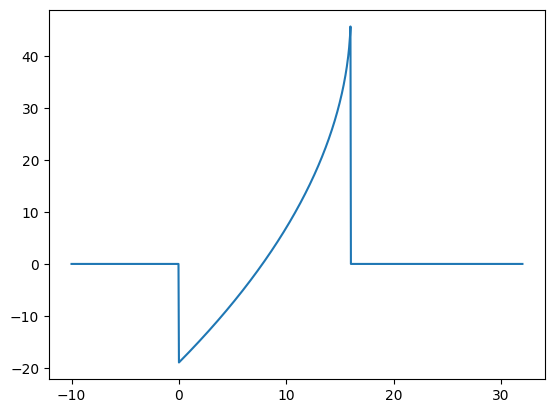

In [8]:
l = 16/x0
x= np.linspace(-10,2*16,1000)/x0
r = []
for i in x:
    r.append(np.array([0,0,i*x0]))
magg = []
for i in r:
    magg.append(mag(i,b_0L,Blab,L)[0])
plt.plot(x*x0,np.array(magg)*1e3)


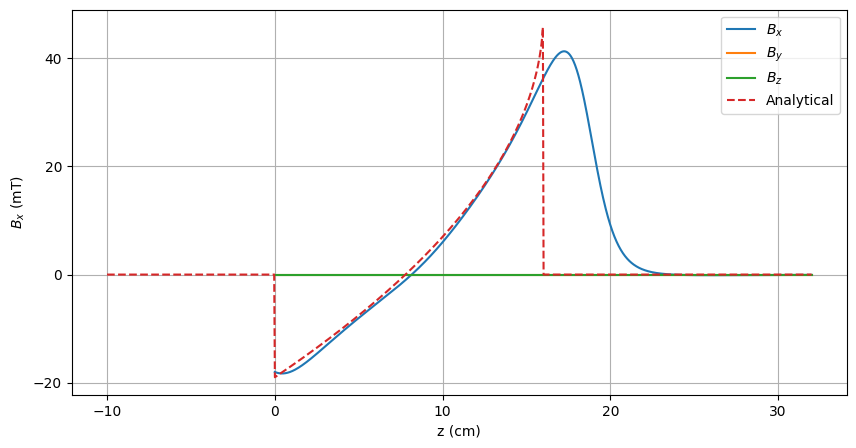

In [9]:
z = np.linspace(0,2*L,1000)
b_y = []
b_z = []
b_x = []
for i in z:
    b_x.append(zeeman_prof.getB([0,0,i*10])[0])
    b_y.append(zeeman_prof.getB([0,0,i*10])[1])
    b_z.append(zeeman_prof.getB([0,0,i*10])[2])
    

fig,ax = plt.subplots(1,1,figsize=(10,5))    
plt.plot(z,np.array(b_x)*1e3)
plt.plot(z,np.array(b_y)*1e3)
plt.plot(z,np.array(b_z)*1e3)
plt.yticks([-20,0,20,40])

plt.xlabel('z (cm)')
plt.plot(x*x0,np.array(magg)*1e3, '--')

plt.ylabel('$B$ (mT)')
plt.legend(['$B_x$','$B_y$','$B_z$','Analytical'])  
plt.ylabel('$B_x$ (mT)')
plt.grid()

In [10]:
zeeman_prof.getB([0,0,0])[0]*1e3

-18.007209902695763

In [11]:
b_z_P = [x for x in b_z if x > 0]
k = z[b_z.index(min(b_z_P))]
print(k)


25.56156156156156


In [12]:
def sat(wavenumber, gamma):

    wavelength = 1 / (wavenumber * 100)
    
    # Saturation intensity formula
    return np.pi * cts.c* cts.h * gamma / (3 * wavelength**3)

wavenumber = 25068.222  # Wavenumber in cm^-1
gamma = 1.93e8  # Decay rate in s^-1
Isat = sat(wavenumber, gamma)
print(Isat)
print(5*Isat*1e3/(100)**2)
Isat*3*(((4*1e-3)**2)*np.pi)*1e3


632.4602794347063
316.23013971735315


95.37276324285222

In [65]:
350**2/(2*(1e-19/mass_lab))

0.1759548708446025

In [13]:
# Now, here are our `natural' length and time scales:
x0 = 1/klab  # cm
t0 = 1/gammalab  # s

mass = mass_lab*(x0*1e-2)**2/cts.hbar/t0

# And now our wavevector, decay rate, and magnetic field gradient in these units:
k = klab*x0
gamma = gammalab*t0
alpha = cts.value('Bohr magneton')*Blab*t0/cts.hbar
b_0 = cts.value('Bohr magneton')*b_0L*t0/cts.hbar 
l = L/x0 

print(x0, t0, mass, k, gamma, alpha,b_0)

6.348872362073421e-06 5.181347150259067e-09 2119.188266564296 1.0 1.0 -30.52874111941582 21.871336921372524


In [14]:
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)
det_1 = np.linspace(0,-20,100)
vc = x0/(t0*100)
# Define the atomic Hamiltonian:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
0, 5/2, 0,  	-0.2592,
    Ahfs = 0, Bhfs=0, Chfs=0,
    muB=1)# ground state 1s0
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
1, 5/2, 1.035,	-0.2592,
    Ahfs=59.52*1e6,Bhfs = 601.87*1e6 , Chfs= 0,
    muB=1) #excited state 1p1

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(0, 1, 5/2)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))
hamiltonian_D2 = pylcp.hamiltonian(mass = mass)
hamiltonian_D2.add_H_0_block('g', H_g_D2)
hamiltonian_D2.add_H_0_block('e', H_e_D2)
hamiltonian_D2.add_d_q_block('g', 'e', dijq_D2, gamma = gamma, k = k)
hamiltonian_D2.add_mu_q_block('g', mu_q_g_D2)
hamiltonian_D2.add_mu_q_block('e', mu_q_e_D2)



#ham = pylcp.hamiltonian(Hg, He, mugq, mueq, dijq, mass=mass, gamma=gamma, k=k)

bf = lambda R: cts.value('Bohr magneton')*b_tot.getB(R*10*x0)*t0/cts.hbar
l = 16/x0
#bf = lambda R: mag(R,b_0,alpha,l)
laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0, 0, -1]), 's': 100,'pol_coord':'spherical', 'pol': 1, 'delta': (E_e_D2[2]-E_g_D2[0]) + -17*gamma},],
    beam_type=pylcp.infinitePlaneWaveBeam) 
linGrad = pylcp.magField(lambda R: bf(R))


In [66]:
300**2/(2*(1e-19/mass_lab))

0.12927296633481

In [16]:
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)


In [68]:
det = np.linspace(-30,0,100)

force_profiles = {}
det = np.linspace(-30,0,100)
j  = 0 
b = 0
#for i in det: 
j = j+1  
laserBeams = pylcp.laserBeams([
{'kvec':np.array([0, 0, -1]), 's': 5,'pol_coord':'spherical', 'pol': np.array([1,0,1]), 'delta': (E_e_D2[2]-E_g_D2[0]) - 15*gamma},],
beam_type=pylcp.infinitePlaneWaveBeam) 
rateeq = pylcp.rateeq(laserBeams, linGrad, hamiltonian_D2, include_mag_forces=True)
x = np.arange(0, 2*L, 0.5)/(x0)
v = np.arange(0, 1000,10)/vc


X, V = np.meshgrid(x, v)

Rvec = np.array([np.zeros(X.shape), np.zeros(X.shape), X])
Vvec = np.array([np.zeros(V.shape), np.zeros(V.shape), V])

rateeq.generate_force_profile(Rvec, Vvec, name='Fz', progress_bar=True)

force_profiles[f'{j}'] = rateeq.profile['Fz'].F[2]

b = b +1
print(b)


c:\Users\benfo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pylcp\rateeq.py:264: ComplexWarning:

Casting complex values to real discards the imaginary part



Completed in 1:40.                                                  
1


C:\Users\benfo\AppData\Local\Temp\ipykernel_10124\74744084.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



Text(0.5, 1.0, 'Contour plot of position vs velocity and force')

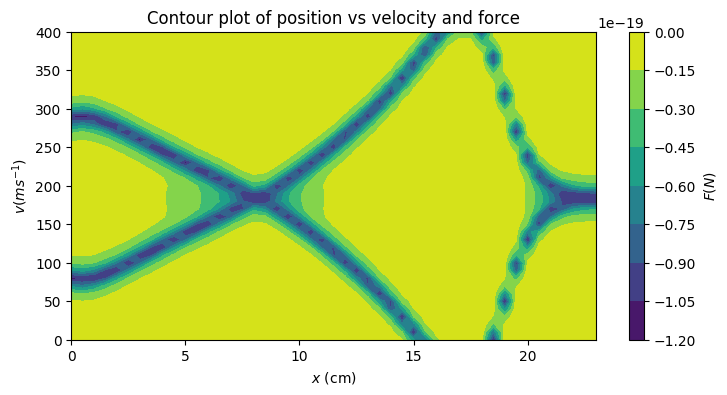

In [69]:
Fc = cts.hbar*klab*gammalab
fig,ax = plt.subplots(1, 1, figsize=(8, 4)) 
cmap_reversed = plt.cm.get_cmap('viridis_r')
Fc = gammalab*cts.hbar*klab*100
im1 = ax.contourf(np.array(x)*x0, np.array(v)*vc, rateeq.profile['Fz'].F[2]*Fc)
fig.subplots_adjust(left=0.08, wspace=0.2)
plt.xlim([0, 23])
plt.ylim([0,400])
cb1 = plt.colorbar(im1)
cb1.set_label('$F(N)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v (ms^{-1})$')
plt.title('Contour plot of position vs velocity and force')

In [70]:
stop =  (350)**2/(2*(1.05*1e-19/mass_lab))
print(stop*100)


16.757606747105


In [20]:
(3e-5*5**(3/2)*0.5)/(8*cts.mu_0*30)*1e3

556.0644867419617

code below plots dynamics directly from pylcp  found this was too slow

In [21]:
# fig,ax = plt.subplots(1,2, figsize=(8,4))
# ax[0].plot(rateeq.sol.t*t0*1e3,rateeq.sol.r[0]*x0)
# ax[1].plot(rateeq.sol.t*t0*1e3,rateeq.sol.v[0]*vc)
# ax[0].set_xlabel('t (ms)')
# ax[0].set_ylabel('z (cm)')
# ax[1].set_xlabel('t (ms)')
# ax[1].set_ylabel('v (m/s)')
# ax[1].yticks = np.arange(0, 200, 100)
# plt.tight_layout()

In [22]:
# import numpy as np

# # Assuming vc, v0, t0, rateeq, etc., are defined elsewhere in your code

# sol_v = []
# sol_r = []
# sol_t = []
# t_span = [0, 0.0013/t0]  # Define the time span for the evolution
# j = 0

# # Generate velocities with a normal distribution
# velocities = np.random.normal(v0, 10, 100)
# rounded_velocities = np.round(velocities, 3) / vc  # Round and normalize velocities

# # Define a reasonable velocity threshold to avoid extreme cases
# velocity_threshold = 10 * v0  # You can adjust this threshold

# for i in range(100):  # Loop over 100 atoms
#     print(j)

#     # Check if the velocity is within a reasonable range
#     if np.abs(velocities[i]) > velocity_threshold:
#         print(f"Skipping atom {j} due to extreme velocity: {velocities[i]}")
#         j += 1
#         continue

#     try:
#         # Set initial velocity and position for rate equations
    #     rateeq.v0 = np.array([rounded_velocities[i], 0., 0.])  # x-velocity only
    #     rateeq.r0 = [0, 0, 0]  # Initial position

    #     # Set the initial population in the Hamiltonian
    #     n0 = np.zeros(rateeq.hamiltonian.n)
    #     n0[0] = 1  # Assume initial population in ground state
    #     rateeq.set_initial_pop(n0)

    #     # Evolve the motion over the time span
    #     rateeq.evolve_motion(t_span,
    #                          progress_bar=True,
    #                          random_recoil=False)

    #     # Append the resulting velocity and position to the solution lists
    #     sol_v.append(rateeq.sol.v[0])
    #     sol_r.append(rateeq.sol.r[0]) 
    #      # Append final velocity in x-direction
    #     sol_t.append(rateeq.sol.t)  # Append final position in x-direction

    # except Exception as e:
    #     print(f"Error evolving atom {j}: {e}")  # Handle any evolution errors

    # j += 1
    



In [23]:
RegularGridInterpolator((v, x), rateeq.profile['Fz'].F[2]*Fc)

done with suvat this was faster 

In [24]:
def find_nearest_value(lst, target):
    nearest = min(lst, key=lambda x: abs(x - target))
    return nearest

In [25]:
f = rateeq.profile['Fz'].F[2]*Fc
f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)*(x0/100)),f,method = 'linear')

In [26]:
x = np.arange(0, 2*L, 0.5)/100
x

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315])

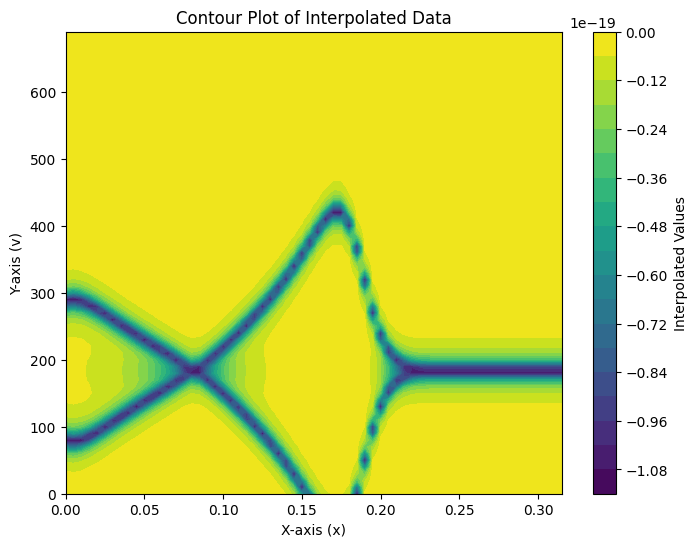

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

  # Example 2D grid of values
L = 16
# Create the interpolator
x = np.arange(0, 2*L, 0.5)/100
f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)),rateeq.profile['Fz'].F[2] * Fc,method='linear')


# Generate a fine grid for plotting
x_fine = np.arange(0, 2*L, 0.5)/100# Fine grid for x-axis
v_fine =  np.arange(0,700 ,10) # Fine grid for v-axis
V,X  = np.meshgrid(v_fine, x_fine)  # Create a 2D grid

# Interpolate on the fine grid
points = np.array([V.flatten(), X.flatten()]).T  # Flatten grid into (n, 2) points
Z = f_interp(points).reshape(X.shape)  # Interpolated values reshaped to grid

# Create the contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, V, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label="Interpolated Values")
plt.xlabel("X-axis (x)")
plt.ylabel("Y-axis (v)")
plt.title("Contour Plot of Interpolated Data")
plt.show()



In [52]:
# Constants
k_B = 1.38065e-23  # Boltzmann constant in J/K
mass_amu = 173  # Atomic mass of Yb-173
mass_kg = mass_amu * 1.66054e-27  # Convert to kilograms
temperature = 405 + 273.15  # Convert Celsius to Kelvin

# Velocity Probability Function
def p(m, T, v):
    return (m / (k_B * T))**2 * np.exp(-m * v**2 / (2 * k_B * T)) * (v**3) / 2


In [53]:
class MaxwellBoltzmann(rv_continuous):
    def _pdf(self, v):
        return p(mass_kg, temperature, v)

# Define the custom distribution
maxwell_boltzmann = MaxwellBoltzmann(a=0, name="Maxwell-Boltzmann")


100


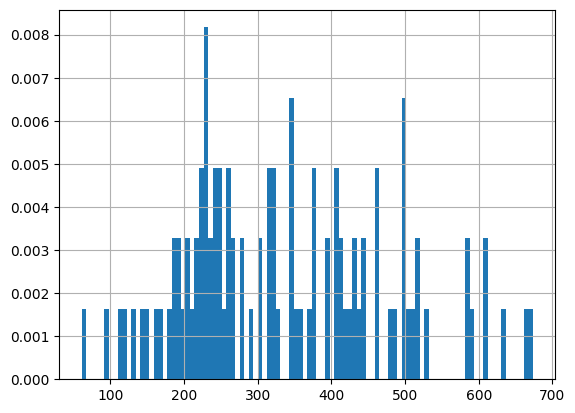

In [54]:
# Generate velocities from the Maxwell-Boltzmann distribution
size = 100# Number of samples
velocities = maxwell_boltzmann.rvs(size=size)

# Display the sampled velocities
print(len(velocities))
plt.hist(velocities, bins=100, density=True)
plt.grid()

In [55]:
x

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
       0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 ,
       0.135, 0.14 , 0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175,
       0.18 , 0.185, 0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 ,
       0.225, 0.23 , 0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265,
       0.27 , 0.275, 0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 ,
       0.315])

In [56]:

# Define the worker function
f = rateeq.profile['Fz'].F[2]*Fc
f_interp = RegularGridInterpolator((np.array(v)*vc,np.array(x)),f,method = 'linear')

def simulate_trajectory(v_0, t_span,f_interp, mass_lab):
    x_t, v_t, t = [], [], []
    s, di = 0, 0  # Initial conditions

    for j in range(len(t_span)):
        dt = t_span[j] - di

        if s > 0.23 or v_0 < 0:  # Break condition
            break

        # Interpolate the force profile
        
        a = f_interp((v_0, s)) / mass_lab

        # Update position and velocity

        s = (1/2)*a*(dt**2) + v_0*dt + s
        
        v_0 = v_0 + a*dt

        # Append values
        x_t.append(s)
        v_t.append(v_0)
        t.append(t_span[j])
        di = t_span[j]
       

    return v_t, x_t, t


In [61]:
v_z = []
z_t = []
t_n = []
t_max = 0.05
t_span = np.linspace(0, t_max, 100000)
velocitiesz = np.linspace(0,400,300)
for i in range(len(velocitiesz)):
    v_t,x_t,t = simulate_trajectory(velocitiesz[i], t_span, f_interp,mass_lab)
    v_z.append(v_t)
    z_t.append(x_t)
    t_n.append(t)


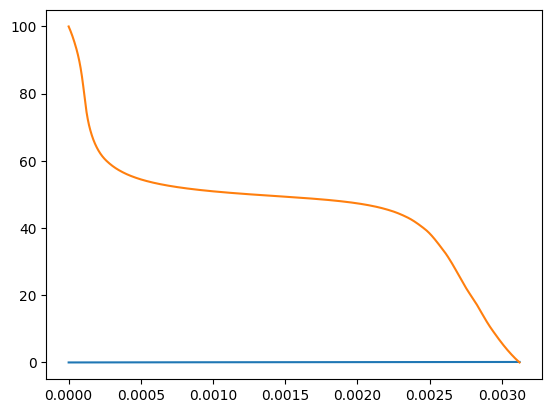

In [62]:
v_t,x_t,t = simulate_trajectory(100,t_span ,f_interp, mass_lab)
plt.plot(t,x_t)
plt.plot(t,v_t)

Text(0, 0.5, 'Final velocity(m/s)')

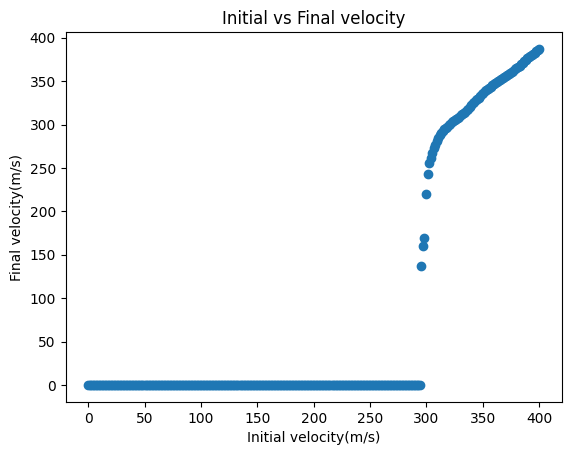

In [63]:
final_vel =  []
intial_vel = []
for i in v_z:
        final_vel.append(i[-1])
        intial_vel.append(i[0])
plt.scatter(intial_vel,final_vel)
plt.title('Initial vs Final velocity')
plt.xlabel('Initial velocity(m/s)')
plt.ylabel('Final velocity(m/s)')